# Imports and define expectation func

In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [2]:
import torch
from FittedModels.utils import plot_samples, plot_sampling_info, plot_divergences
torch.manual_seed(5)
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from FittedModels.train import LearntDistributionManager
from Utils.plotting_utils import plot_func2D
from Utils.numerical_utils import MC_estimate_true_expectation
from Utils.numerical_utils import quadratic_function as expectation_function
from FittedModels.Models.FlowModel import FlowModel
from FittedModels.utils import plot_history
import matplotlib.pyplot as plt
from TargetDistributions.MoG import MoG
import pathlib
from datetime import datetime
torch.set_default_dtype(torch.float64)

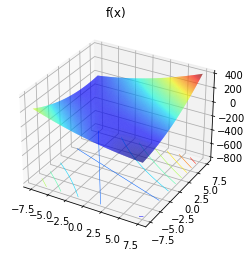

In [3]:
expectation_func_fig = plot_func2D(expectation_function, n_points=200, range=15)

# Lumpy High Dimension Flow Target Distribution

In [4]:
epochs = int(5e3)
batch_size = int(1e3)
dim = 10
n_samples_estimation = int(5e6)
KPI_n_samples = int(1e4)
lr = 1e-3
optimizer = "Adamax"
flow_type = "IAF" #"RealNVP"
n_flow_steps = 3  # 5
prior_scaling_factor = 10.0

In [5]:
torch.manual_seed(0)
target = MoG(dim=dim, n_mixes=10, min_cov=0, loc_scaling=3)
print(target.covs.device)
true_expectation = MC_estimate_true_expectation(target, expectation_function, n_samples_estimation)
print(true_expectation)
print(MC_estimate_true_expectation(target, expectation_function, n_samples_estimation)) # print twice to make sure estimates are resonably close
target.to("cuda")
print(target.covs.device)

cpu
tensor(20.8094)
tensor(20.8046)
cuda:0


## Small Test of IAF speed vs RealNVP Speed
IAF roughly 50% slower at 10 dimensions

In [ ]:
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, scaling_factor=5.0)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG", lr=1e-3)
history = tester.train(50, batch_size=100, clip_grad=True, max_grad_norm=1)

In [ ]:
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, scaling_factor=5.0, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG", lr=1e-3)
history = tester.train(50, batch_size=100, clip_grad=True, max_grad_norm=1)

# DReG, alpha=1, then alpha = 2

In [11]:
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=n_flow_steps, scaling_factor=prior_scaling_factor, flow_type=flow_type)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG_kl",
                                   lr=lr, optimizer=optimizer, k=100, use_GPU = False)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

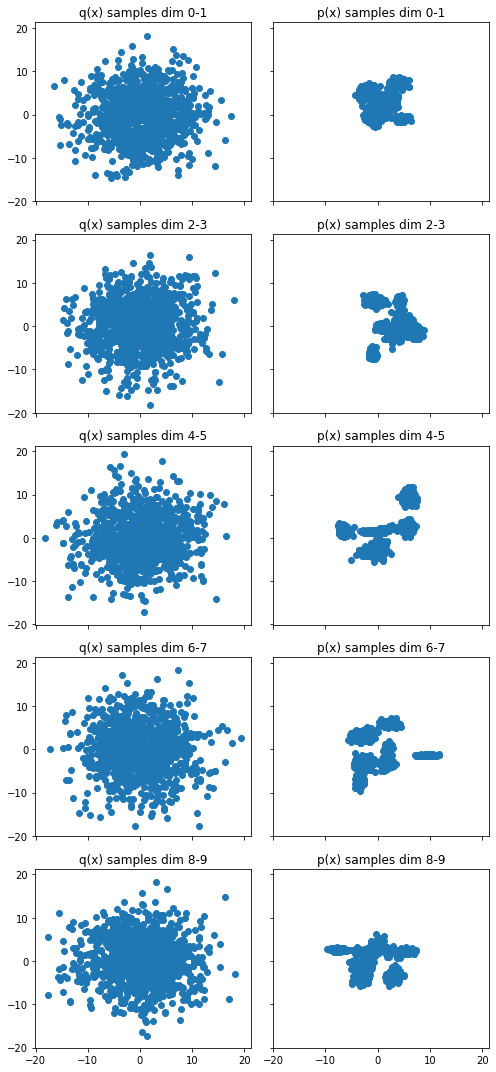

In [12]:
samples_fig_before = plot_samples(tester) # this just looks at 2 dimensions

In [13]:
epochs = int(1e3)

In [14]:
history = tester.train(epochs, batch_size=batch_size, clip_grad=True, max_grad_norm=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [15]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 20.809431185257854 
estimate before training is 70.03436058291469 
estimate after training is 9.305269926526693 
effective sample size before is 6.997993253083591e-07
effective sample size after train is 2.6325930538879524e-06
variance in weights is 1.519410781652291e-08


In [16]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 20.809431185257854 
estimate before training is 70.03436058291469 
estimate after training is 33.824947373880214 
effective sample size before is 6.997993253083591e-07
effective sample size after train is 9.342181084069787e-07
variance in weights is 4.28165224694733e-08


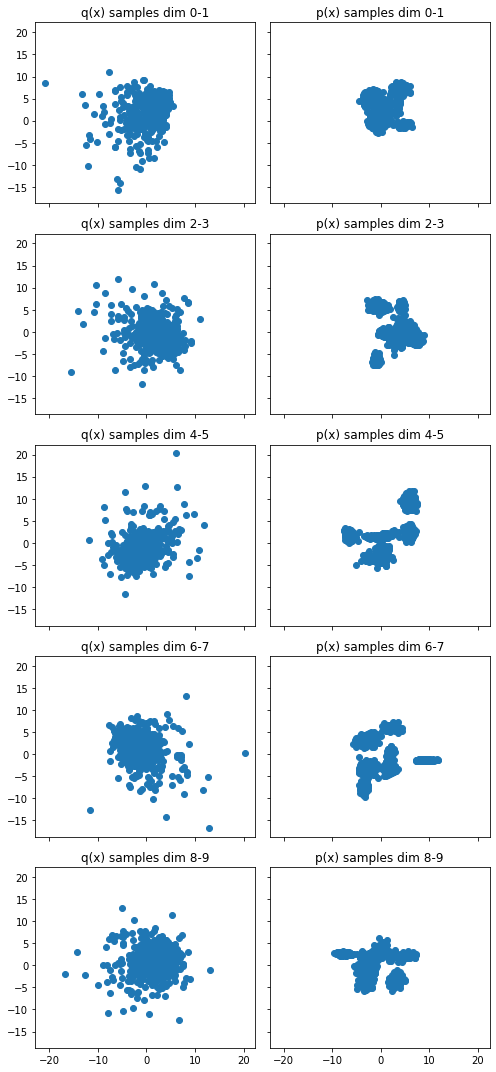

In [17]:
plot_samples(tester)

NaN encountered in alpha_2_divergence_over_p history


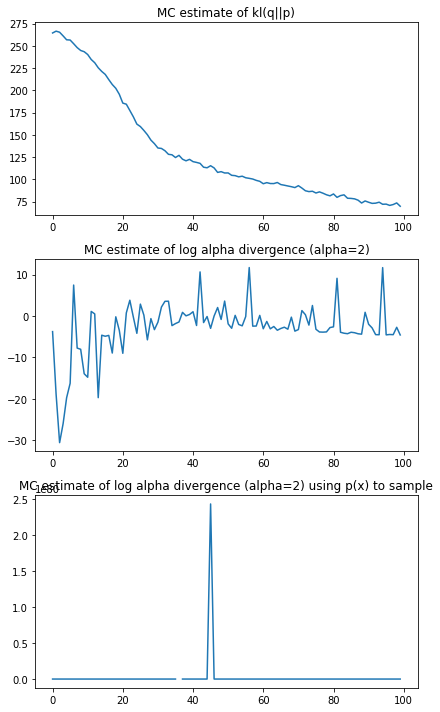

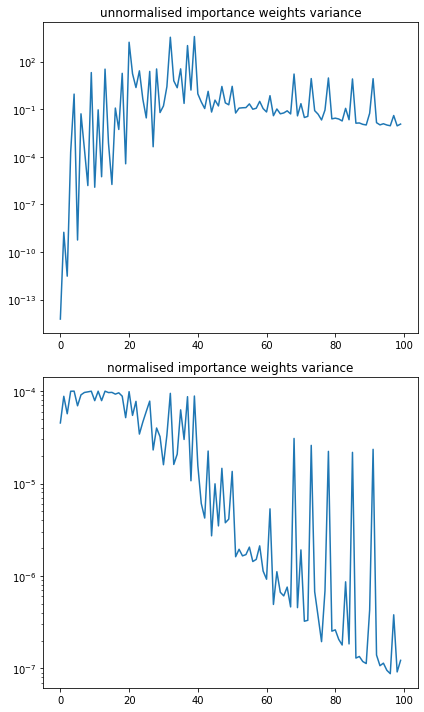

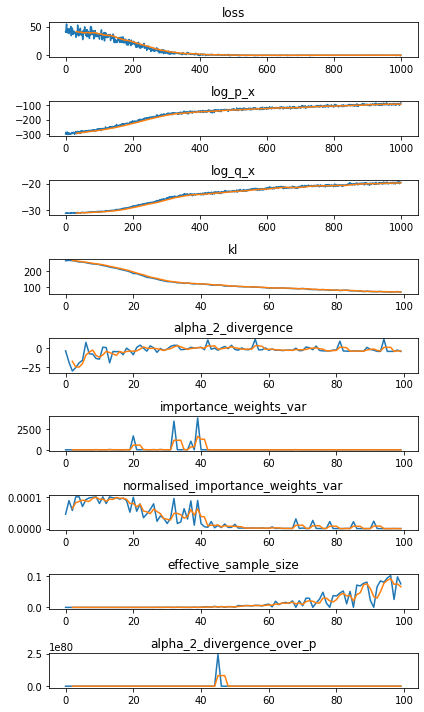

In [18]:
plot_divergences(history)
plot_sampling_info(history)
hist_plot = plot_history(history)

## Now change to DReG alpha=2 loss

In [19]:
tester.setup_loss("DReG", alpha=2, k=None, new_lr=1e-4)

In [20]:
history = tester.train(epochs, batch_size=batch_size, clip_grad=True, max_grad_norm=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [21]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 20.809431185257854 
estimate before training is 70.03436058291469 
estimate after training is 11.04432982645752 
effective sample size before is 6.997993253083591e-07
effective sample size after train is 1.3189541008427507e-06
variance in weights is 3.0327025947626126e-08


In [22]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 20.809431185257854 
estimate before training is 70.03436058291469 
estimate after training is 26.104780647842095 
effective sample size before is 6.997993253083591e-07
effective sample size after train is 1.767841617271776e-06
variance in weights is 2.2626425858348573e-08


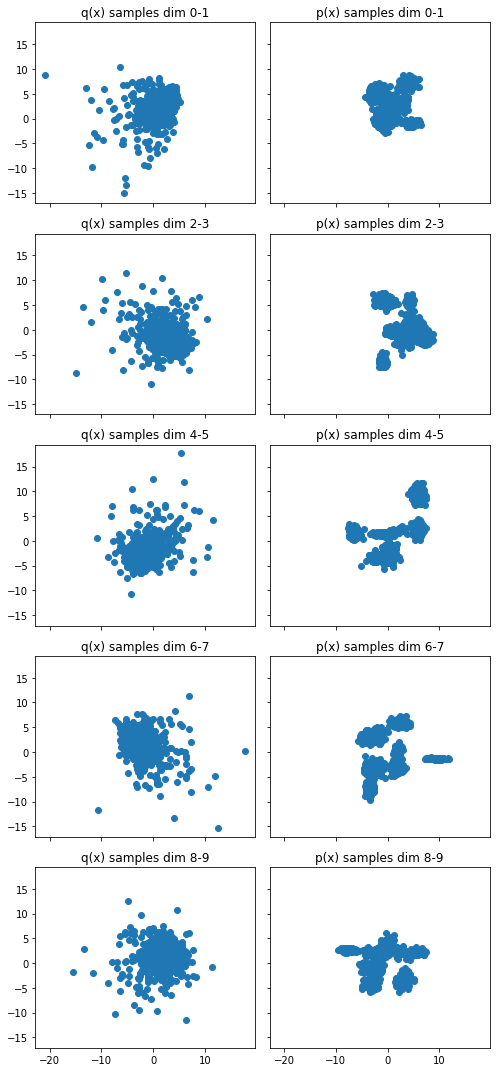

In [23]:
plot_samples(tester)

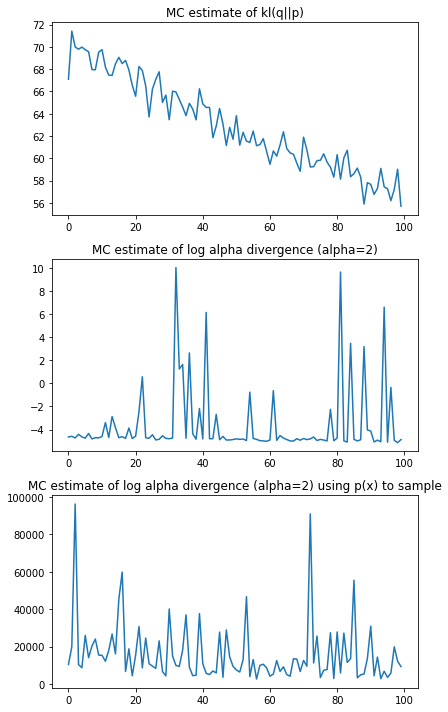

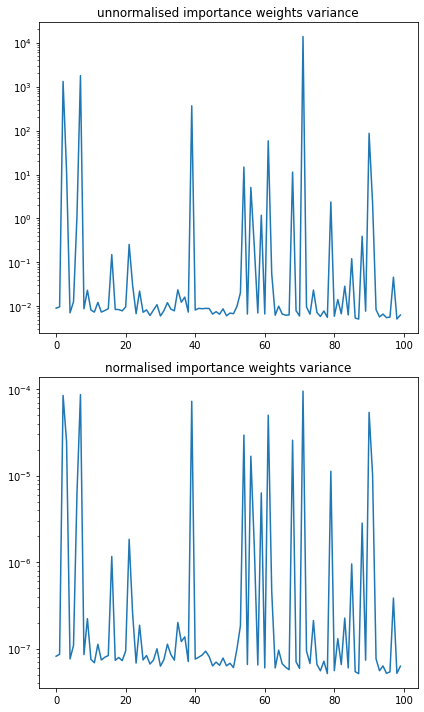

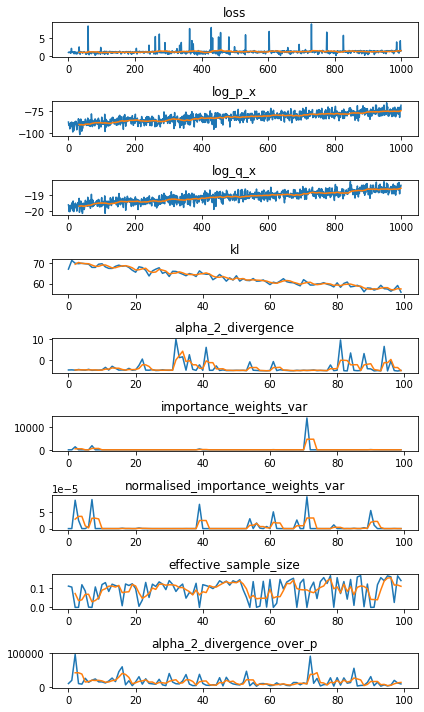

In [24]:
plot_divergences(history)
plot_sampling_info(history)
hist_plot = plot_history(history)

# DReG, alpha=2

In [6]:
epochs = int(1e4)
batch_size = int(1e3)
dim = 10
n_samples_estimation = int(5e6)
KPI_n_samples = int(1e4)
lr = 5e-5
optimizer = "Adamax"
flow_type = "IAF" #"RealNVP"
n_flow_steps = 3  # 5
prior_scaling_factor = 10.0

In [7]:
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=n_flow_steps, scaling_factor=prior_scaling_factor, flow_type=flow_type)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG",
                                   lr=lr, optimizer=optimizer) #, use_GPU=False)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

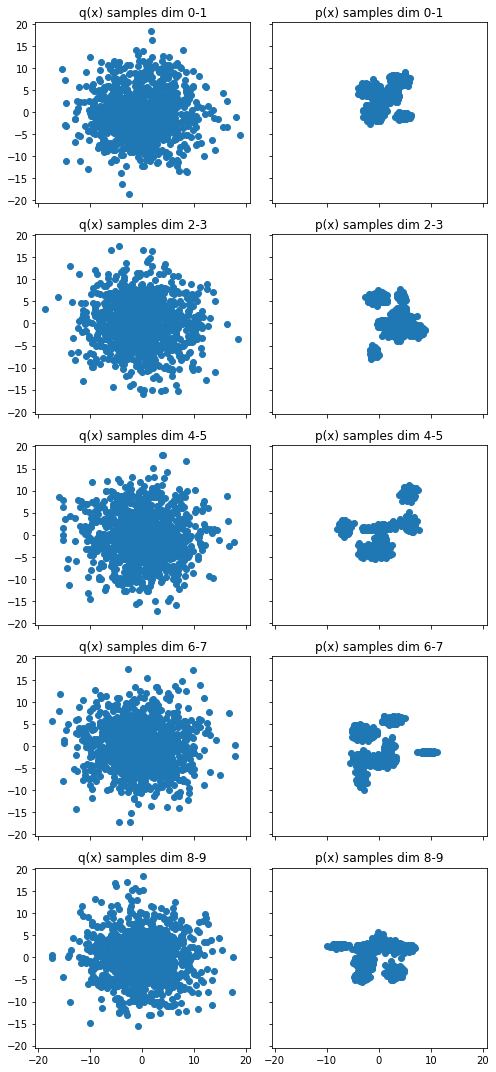

In [8]:
samples_fig_before = plot_samples(tester)

In [9]:
history = tester.train(epochs, batch_size=batch_size, clip_grad=True, max_grad_norm=1)

loss: -22.415079393527282, mean log p_x -341.7439298066189: 100%|██████████| 10000/10000 [31:22<00:00,  5.31it/s]


In [10]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 20.809431185257854 
estimate before training is 70.03436058291469 
estimate after training is 9.275507709992123 
effective sample size before is 6.997993253083591e-07
effective sample size after train is 4.505748389473788e-07
variance in weights is 8.877546307674785e-08


In [11]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 20.809431185257854 
estimate before training is 70.03436058291469 
estimate after training is 9.275507709992123 
effective sample size before is 6.997993253083591e-07
effective sample size after train is 4.505748389473788e-07
variance in weights is 8.877546307674785e-08


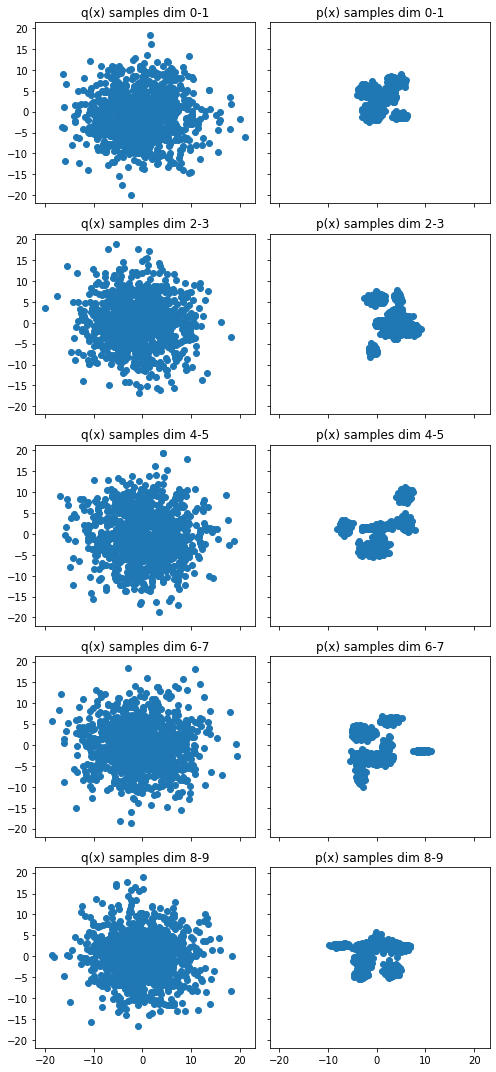

In [12]:
samples_fig_after = plot_samples(tester)

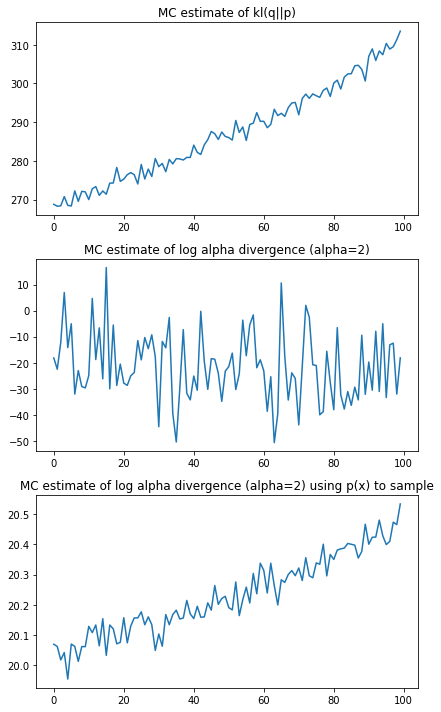

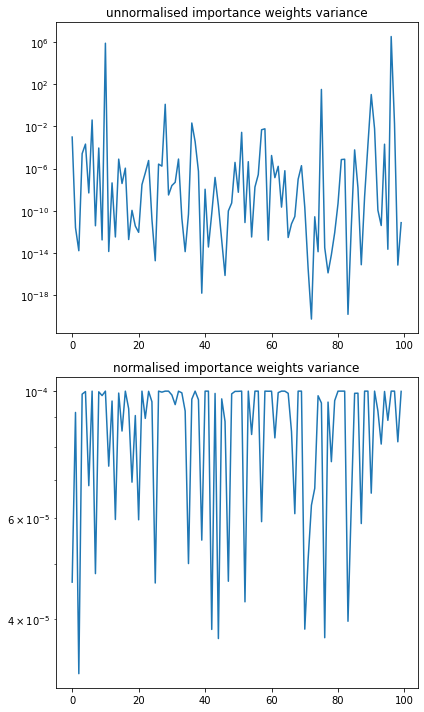

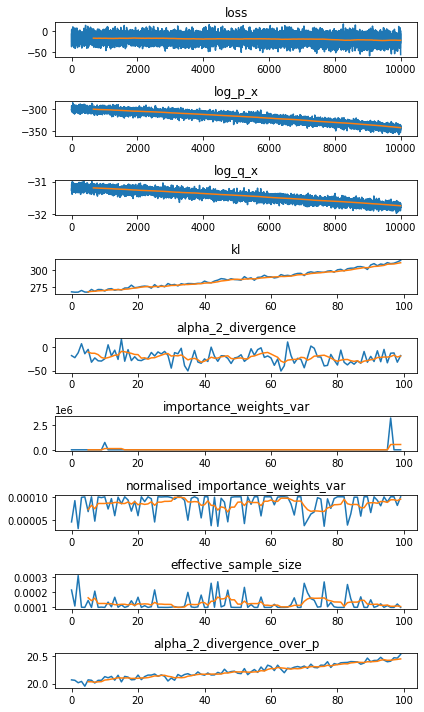

In [13]:
plot_divergences(history)
plot_sampling_info(history)
hist_plot = plot_history(history)

# KL

In [ ]:
torch.manual_seed(1)
learnt_sampler_kl = FlowModel(x_dim=dim, n_flow_steps=3, scaling_factor=5.0) #, flow_type="RealNVP")
tester_kl = LearntDistributionManager(target, learnt_sampler_kl, VanillaImportanceSampling, loss_type="kl", lr=1e-3)
expectation_before_kl, info_before_kl = tester_kl.estimate_expectation(n_samples_estimation, expectation_function)

In [ ]:
samples_fig_before = plot_samples(tester_kl)

In [ ]:
history_kl = tester_kl.train(epochs, batch_size=batch_size)

In [ ]:
expectation_kl, info_kl = tester_kl.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before_kl} \n"
      f"estimate after training is {expectation_kl} \n" 
     f"effective sample size before is {info_before_kl['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info_kl['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info_kl['normalised_sampling_weights'])}")

In [ ]:
expectation_kl, info_kl = tester_kl.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before_kl} \n"
      f"estimate after training is {expectation_kl} \n" 
     f"effective sample size before is {info_before_kl['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info_kl['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info_kl['normalised_sampling_weights'])}")

In [ ]:
samples_fig_after = plot_samples(tester_kl)

In [ ]:
plot_divergences(history_kl)

In [ ]:
plot_sampling_info(history_kl)

In [ ]:
hist_plot = plot_history(history_kl)

# DReG, kl

In [ ]:
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=n_flow_steps, scaling_factor=prior_scaling_factor, flow_type=flow_type)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG_kl",
                                   lr=lr, optimizer=optimizer)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

In [ ]:
samples_fig_before = plot_samples(tester) # this just looks at 2 dimensions

In [ ]:
history = tester.train(epochs, batch_size=batch_size, clip_grad=True, max_grad_norm=1)

In [ ]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

In [ ]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

In [ ]:
samples_fig_after = plot_samples(tester)

In [ ]:
plot_divergences(history)

In [ ]:
plot_sampling_info(history)

In [ ]:
hist_plot = plot_history(history)